<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup-imports-and-folder-paths" data-toc-modified-id="Setup-imports-and-folder-paths-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup imports and folder paths</a></span></li><li><span><a href="#Map-creation,-Thymio-and-objective-localisation-(measurements)" data-toc-modified-id="Map-creation,-Thymio-and-objective-localisation-(measurements)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Map creation, Thymio and objective localisation (measurements)</a></span><ul class="toc-item"><li><span><a href="#Extracting-the-corners" data-toc-modified-id="Extracting-the-corners-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Extracting the corners</a></span></li></ul></li><li><span><a href="#Connection-to-the-Thymio" data-toc-modified-id="Connection-to-the-Thymio-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Connection to the Thymio</a></span></li><li><span><a href="#Moving-the-Thymio" data-toc-modified-id="Moving-the-Thymio-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Moving the Thymio</a></span><ul class="toc-item"><li><span><a href="#Example-of-setting-and-getting-the-left-and-right-motor-speeds" data-toc-modified-id="Example-of-setting-and-getting-the-left-and-right-motor-speeds-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Example of setting and getting the left and right motor speeds</a></span></li><li><span><a href="#Rotating-the-thymio" data-toc-modified-id="Rotating-the-thymio-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Rotating the thymio</a></span></li></ul></li></ul></div>

## Setup imports and folder paths

In [1]:
!pip install --user opencv-contrib-python

In [1]:
# ========================================================================== #
#  Imports.                                                                  # 
# ========================================================================== #

import os
import sys
import matplotlib.pyplot as plt
import cv2

# ========================================================================== #
#  Folder paths.                                                             # 
# ========================================================================== #

sys.path.insert(1, 'src')
sys.path.insert(1, 'img')

## Map creation, Thymio and objective localisation (measurements)
The map is created using the functions defined in the file **create_map.py**. The first step is to be able to rectify the image taken by the camera. This is done by using red markers for each corner of the map, and using their position to compute a transform matrix that will be used to get a rectified image.

In [4]:
# ========================================================================== #
#  Imports.                                                                  # 
# ========================================================================== #

from create_map import *
from img_utils import *

# Read different images to test the robustness of the map creation process
img = cv2.imread('img/map_test2.png')
img_noisy = cv2.imread('img/map_test_noisy.png')
img_vert = cv2.imread('img/map_test4.png')

### Extracting the corners
This is simply done by converting the map into HSV color space. We can then easily extract the color using a range of angles and luminances.

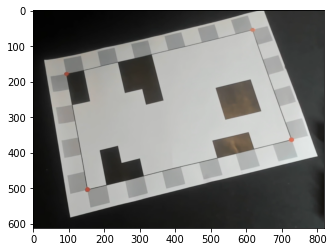

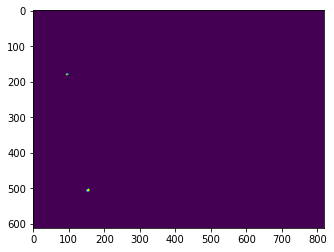

In [5]:
# convert to hsv space
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# extract a certain color
mask = cv2.inRange(hsv, RED_THR_HSV_LOW, RED_THR_HSV_HIGH)
# erode mask to avoid noise
kernel = np.ones((2,2),np.uint8)
mask = cv2.erode(mask,kernel,iterations = 3)

plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.figure()
plt.imshow(mask)

We can then extract the coordinates of the corners. The corners are sorted from biggest dot to smallest dot. This is done to be able to select the dots that are less likely to be noise (we can specify how many dots we expect to be returned). The corners are calculated by computing the centroid of the dots.

Noisy picture: [(108, 465), (702, 466), (679, 130), (256, 365)]
Noisy picture, 4 biggest dots: [(108, 465), (702, 466), (679, 130), (256, 365)]
Found all dots.
Failed to find the requested number of dots.


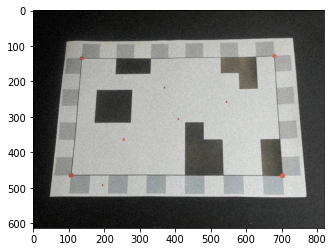

In [6]:
dots, found_dots = get_color_dots(img_noisy, RED_THR_HSV_LOW, RED_THR_HSV_HIGH)
plt.figure()
plt.imshow(cv2.cvtColor(img_noisy, cv2.COLOR_BGR2RGB))
# With a noisy picture, we get more than 4 corners.
print("Noisy picture: {}".format(dots))

# We can filter this by specifying how many dots we expect
dots, found_dots = get_color_dots(img_noisy, RED_THR_HSV_LOW, RED_THR_HSV_HIGH, 4)
print("Noisy picture, 4 biggest dots: {}".format(dots))
if found_dots:
    print("Found all dots.")
else:
    print("Failed to find the requested number of dots.")

# The function returns False if we try to get more dots than there are on the picture
dots, found_dots = get_color_dots(img_noisy, RED_THR_HSV_LOW, RED_THR_HSV_HIGH, 6)
if found_dots:
    print("Found all dots.")
else:
    print("Failed to find the requested number of dots.")

Below is an example of a map creation from a picture. The function **create_map** returns the transform matrix used to rectify the image, the width and height of the rectified image, the map and its enlarged version as matrices, and a boolean value indicating if the map was successfully computed. The **create_map** function has to be called with known dimensions (known number of cells in the x and y axis).

Image dimensions are 819 x 613
Map was not successfully computed.


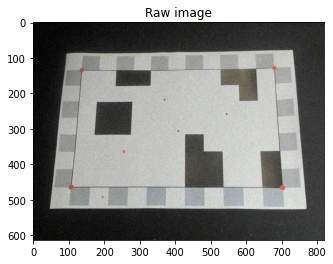

In [7]:
# ========================================================================== #
#  Example 1                                                                 # 
# ========================================================================== #

plt.figure()
plt.imshow(cv2.cvtColor(img_noisy, cv2.COLOR_BGR2RGB))
plt.title("Raw image")

# Initialize map
M, rect_width, rect_height, map, map_enlarged, success = create_map(img_noisy, 11, 7, verbose = True)
if success:
    
    plt.figure()
    plt.imshow(map, origin = 'lower')
    plt.title("Original Map")
    plt.gca().invert_yaxis()
    
    plt.figure()
    plt.imshow(map_enlarged, origin = 'lower')
    plt.title("Map enlarged")
    plt.gca().invert_yaxis()
    
    # We can now get the rectified image using the warp transform matrix
    # Separating the processes allow us to recalculate quickly the rectified map
    # without having to recalculate the warp transform matrix (assuming fixed camera).
    img_rect = get_rectified_img(img_noisy, M, rect_width, rect_height)
    plt.figure()
    plt.imshow(cv2.cvtColor(img_rect, cv2.COLOR_BGR2RGB))
    plt.title("Rectified image")
    plt.show()
else:
    print("Map was not successfully computed.")

In [ ]:
# ========================================================================== #
#  Example 2                                                                 # 
# ========================================================================== #

plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Raw image")

# Initialize map
M, rect_width, rect_height, map, map_enlarged, success = create_map(img, 11, 7, verbose = True)
if success:
    
    plt.figure()
    plt.imshow(map, origin = 'lower')
    plt.title("Original Map")
    plt.gca().invert_yaxis()
    
    plt.figure()
    plt.imshow(map_enlarged, origin = 'lower')
    plt.title("Map enlarged")
    plt.gca().invert_yaxis()
    
    # We can now get the rectified image using the warp transform matrix
    # Separating the processes allow us to recalculate quickly the rectified map
    # without having to recalculate the warp transform matrix (assuming fixed camera).
    img_rect = get_rectified_img(img, M, rect_width, rect_height)
    plt.figure()
    plt.imshow(cv2.cvtColor(img_rect, cv2.COLOR_BGR2RGB))
    plt.title("Rectified image")
    plt.show()
else:
    print("Map was not successfully computed.")

## Connection to the Thymio

To ensure that the program can be run on different computers and with different connection types (cable, wireless), we first identify the Thymio VID (Vendor ID) and put it in a list (in case of multiple Thymios, we can have multiple VIDs). When connecting, the program checks for the VID of each serial port, and initiates a communication if a matching VID is found.

In [10]:
# ========================================================================== #
#  Imports.                                                                  # 
# ========================================================================== #

from MyThymio import *
from thymio_connection import *
import time

First, display ports VIDs. This will then have to be manually put in the **THYMIO_VID** list which contains a list of possible VIDs.

In [11]:
check_vid()

Port: COM16, VID: None
Port: COM8, VID: None
Port: COM11, VID: None
Port: COM22, VID: None
Port: COM14, VID: 1559
Port: COM13, VID: None
Port: COM10, VID: None
Port: COM12, VID: None
Port: COM21, VID: None


It is then possible to automatically connect to the right port, if the matching VID is found.

In [12]:
thymio = MyThymio()

## Moving the Thymio

### Example of setting and getting the left and right motor speeds

In [14]:
print("Target right speed: {}".format(100))
print("Target left speed: {}".format(50))
thymio.set_motor_right_speed(100)
thymio.set_motor_left_speed(50)
time.sleep(0.5)
print("Right speed: {}".format(thymio.get_motor_right_speed()))
print("Left speed: {}".format(thymio.get_motor_left_speed()))
time.sleep(1)
print("Stopping the motors.")    
thymio.stop_thymio()
time.sleep(0.5)
print("Right speed: {}".format(thymio.get_motor_right_speed()))
print("Left speed: {}".format(thymio.get_motor_left_speed()))
time.sleep(1)

Target right speed: 100
Target left speed: 50
Right speed: 101
Left speed: 54
Stopping the motors.
Right speed: 0
Left speed: 0


### Rotating the thymio
Below are the tests that were conducted to determine the rotation coefficient. We will refer to this post on StackOverflow for the timer generation: https://stackoverflow.com/a/40965385

In [15]:
# ========================================================================== #
#  Imports.                                                                  # 
# ========================================================================== #

import threading
import math
import numpy as np

In [16]:

class RepeatedTimer(object):
  def __init__(self, interval, function, *args, **kwargs):
    self._timer = None
    self.interval = interval
    self.function = function
    self.args = args
    self.kwargs = kwargs
    self.is_running = False
    self.next_call = time.time()
    self.start()

  def _run(self):
    self.is_running = False
    self.start()
    self.function(*self.args, **self.kwargs)

  def start(self):
    if not self.is_running:
      self.next_call += self.interval
      self._timer = threading.Timer(self.next_call - time.time(), self._run)
      self._timer.start()
      self.is_running = True

  def stop(self):
    self._timer.cancel()
    self.is_running = False

The program below is used to find the coefficient of rotation, which is calculated in order to calculate the time necessary to wait before stopping the motors after initiating a rotation. We have to press the forward button to start the timer, and the backward button to stop it once it has completed the defined amount of turns (here 5). We then press the forward button again, and the timer starts again, but this time with the Thymio rotating at a higher speed. We can then select the rotation coefficient corresponding to the base speed that we want to use. 

In [21]:
BASE_SPEED_TEST = 100
DELTA_SPEED = 0
NUM_TURNS = 5
NUM_TESTS = 2
timer_running = False
t = 0

Ts = 0.1
Ts_ms = 100
def timer():
    global timer_running, t
    if (thymio.ser.get_var("button.forward") == 1) and (timer_running == False):
        t = 0
        timer_running = True
        print("Starting timer...")
        thymio.set_motor_speeds(BASE_SPEED_TEST, -BASE_SPEED_TEST)
    if timer_running:
        t = t + Ts_ms
test_cnt = 0
rot_coeff = np.zeros(NUM_TESTS)
speed_lst = np.zeros(NUM_TESTS)
while test_cnt < NUM_TESTS:
    rt = RepeatedTimer(Ts, timer)
    try:
        while thymio.ser.get_var("button.backward") != 1:
            time.sleep(0.1)
    finally:
        speed_lst[test_cnt] = BASE_SPEED_TEST
        thymio.stop_thymio()
        timer_running = False
        rt.stop()
        print("Time [ms]:  {}".format(t))
        rot_coeff[test_cnt] = t/(NUM_TURNS*2*math.pi)
        test_cnt = test_cnt + 1
        BASE_SPEED_TEST = BASE_SPEED_TEST + DELTA_SPEED
        while thymio.ser.get_var("button.backward") == 1: # debouncing
            time.sleep(0.1)
for i in range(len(speed_lst)):
    print("Speed: {} \t Rotation coefficient: {}".format(speed_lst[i], rot_coeff[i]/1000))

Starting timer...
Time [ms]:  46700
Starting timer...
Time [ms]:  50000
Speed: 100.0 	 Rotation coefficient: 1.4865071684783024
Speed: 100.0 	 Rotation coefficient: 1.5915494309189535


Plotting the rotation coefficient against the base speed, we might think that it is linear. This is however not the case, which means that we cannot easily guess the rotation coefficient from the base speed using a linear fit (base_speed * rot_coeff is not a constant). Thus, it is more accurate to first choose a base speed, and then calculate the corresponding rotation coefficient instead of trying to find a relationship between the two. The final rotation coefficients that were found are listed in **thymio_utils.py**.

In [17]:
m,b = np.polyfit(np.reciprocal(speed_lst), rot_coeff, 1)
plt.plot(np.reciprocal(speed_lst), rot_coeff, '.')

NameError: name 'speed_lst' is not defined

In [10]:
rotate_thymio(th, -2*math.pi)
time.sleep(1)
rotate_thymio(th, 2*math.pi)